In [299]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [300]:
import sys
sys.path.insert(0, '/home/mritter/code/preposterous')

In [301]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import scipy.stats
import preposterous.preposterous as pp

In [306]:
pdf = pp.PrePostDF()
pdf.add_intervention(filename='data/reporter20180915.csv')
pdf.add_outcome(filename='data/reporter20180915.csv')

/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [307]:
pdf.basic_info()

Earliest recording: 2018.07.04
Latest recording: 2018.09.15
Recordings per day: 12.1

Outcomes with n>5:
                          n   pct
                        247  0.55
Noticeable- definitely   76  0.17
Noticeable- barely       53  0.12
Totally fine             36  0.08
Distracting              34  0.08

Interventions with n>5:
                             n   pct
Tums1x                      18  0.15
Tummy Drop (1ct)            15  0.12
Ginger tea                  15  0.12
Nex                         14  0.11
GinGin2x                    14  0.11
Motion sickness medication   8  0.07
Peppermint TD (2ct)          7  0.06
Mineral water                7  0.06
Tummy Drop (2ct)             7  0.06

Long dataframe tail:
                    intervention      outcome
2018-07-07 13:49:51          NaN  Distracting
2018-07-15 11:01:27          NaN  Distracting
2018-07-15 11:01:27          NaN  Distracting
2018-07-17 10:36:46          NaN             
2018-07-17 10:36:46          NaN            

In [308]:
pdf.outcomes(
    positive_outcomes=['Totally fine', 'Noticeable- barely'],
    negative_outcomes=['Noticeable- definitely', 'Distracting'],
    window=3
)

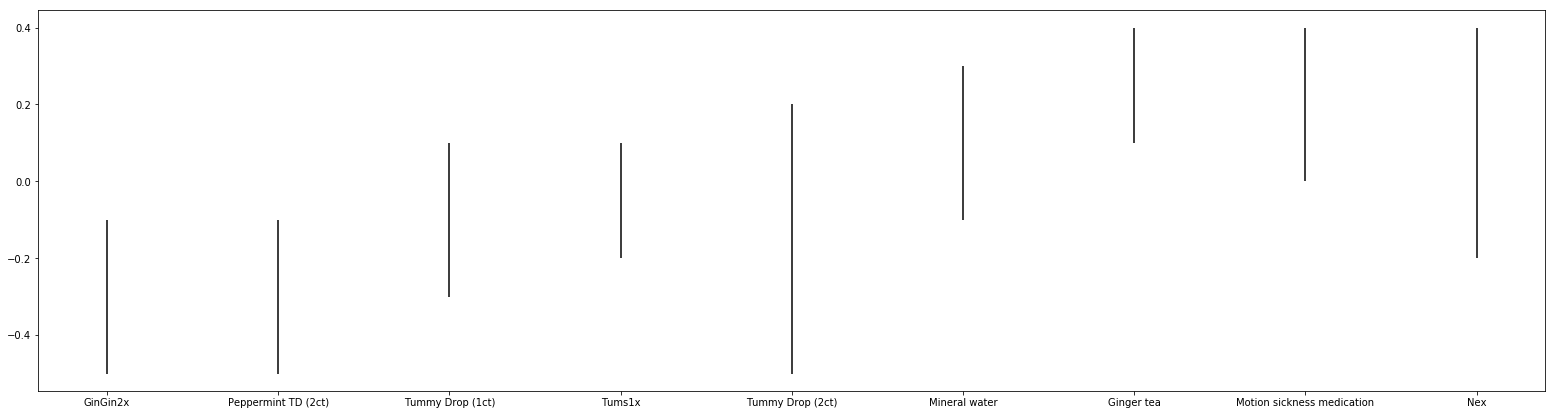

In [309]:
pdf.calculate_relative_effectiveness()
_ = pdf.plot_relative_effectiveness()

## Period Intervention

In [8]:
pdf.df.tail()

intervention      outcome
2018-07-07 13:49:51          NaN  Distracting
2018-07-15 11:01:27          NaN  Distracting
2018-07-15 11:01:27          NaN  Distracting
2018-07-17 10:36:46          NaN             
2018-07-17 10:36:46          NaN

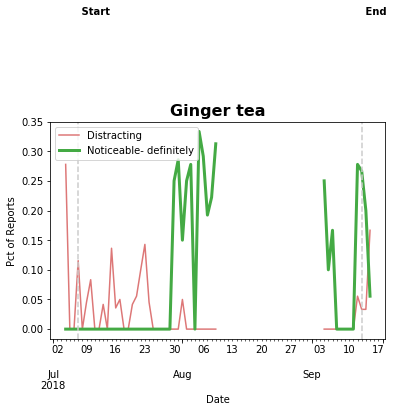

In [9]:
intervention = 'Nex'
def plot_prepost(df, intervention):
    assert intervention in df.intervention.unique()
    min_day = df[df.intervention == intervention].index.min()
    max_day = df[df.intervention == intervention].index.max()
    s = pd.get_dummies(df['outcome'])[['Distracting', 'Noticeable- definitely']].groupby(pd.Grouper(freq='1d')).mean()
    ax = s['Distracting'].plot(c='#DD7777')
    ax = s['Noticeable- definitely'].plot(linewidth=3, c='#44AA44')
    ax.axvline(min_day, c='#CCCCCC', linestyle='--')
    ax.text(min_day, .53, ' Start', fontdict={'weight':'bold'})
    ax.axvline(max_day, c='#CCCCCC', linestyle='--')
    ax.text(max_day, .53, ' End', fontdict={'weight':'bold'})
    ax.set_xlabel('Date')
    ax.set_ylabel('Pct of Reports')
    ax.set_title(intervention, fontdict={'weight':'bold', 'fontsize':16})
    ax.legend()
#     ax.get_figure().savefig('results/{}_{:%Y%m%d}.png'.format(intervention.replace(' ', '_'), pd.datetime.today()))
    return ax

_ = plot_prepost(pdf.df, 'Ginger tea')

2018-07-04 20:22:00 2018-07-12 19:27:19 2018-07-22 23:08:58


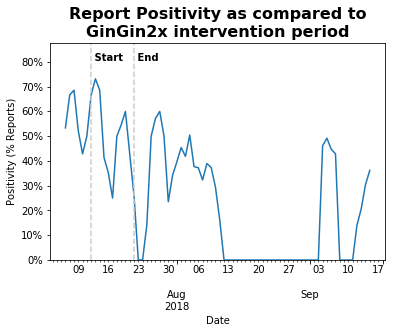

In [348]:
# Take intervention and good and bad outcome
df = pdf.df.sort_index()
positive_outcomes=['Totally fine', 'Noticeable- barely']
negative_outcomes=['Noticeable- definitely', 'Distracting']
intervention = 'GinGin2x' #'Ginger tea'

# Sanity check
if intervention not in df.intervention.unique():
    raise ValueError("Intervention {} is not in the dataset")

outcomes = set(filter(lambda x: len(x), df.outcome.fillna('').unique()))
for outcome in positive_outcomes + negative_outcomes:
    if outcome not in outcomes:
        raise ValueError("Outcome {} is not in the dataset")


# Define data start, intervention start, and post-interventino start timestamp
data_start = df[df.outcome.isin(positive_outcomes+negative_outcomes)].index.min()
intervention_start = df[df.intervention == intervention].index.min()
intervention_end = df[df.intervention == intervention].index.max()
print(data_start, intervention_start, intervention_end)

# Calc % good 
outcome_cnt = pd.concat([
    df[df.outcome.isin(positive_outcomes)].groupby(pd.Grouper(freq='1d')).size(),
    df[df.outcome.isin(negative_outcomes)].groupby(pd.Grouper(freq='1d')).size(),
], axis=1, keys=['positive', 'negative'])
outcome_cnt['pct'] = outcome_cnt.positive.fillna(0).div(outcome_cnt.sum(axis=1))
outcome_cnt['pct_rolling3'] = outcome_cnt.positive.fillna(0).rolling(3).sum().div(outcome_cnt.sum(axis=1).rolling(3).sum())


# plot
ymax, ymin = outcome_cnt.pct_rolling3.apply([np.max, np.min])
yrange = ymax - ymin
label_height = ymin + yrange * 1.1

ax = outcome_cnt.pct_rolling3.plot()
ax.set_ylim([ymin, ymax*1.2])
ax.axvline(intervention_start, c='#CCCCCC', linestyle='--')
ax.text(intervention_start, label_height, ' Start', fontdict={'weight':'bold'})
ax.axvline(intervention_end, c='#CCCCCC', linestyle='--')
ax.text(intervention_end, label_height, ' End', fontdict={'weight':'bold'})
ax.set_xlabel('Date')
ax.set_ylabel('Positivity (% Reports)')
ax.set_title('Report Positivity as compared to\n{} intervention period'.format(intervention), fontdict={'weight':'bold', 'fontsize':16})
_ = ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

## Exploration 

### Where is the breakpoint for the new data?

In [292]:
df2 = df.copy() #[(df.outcome.notnull()) & (df.outcome != '')]
# df2 = 
hour = pd.Series((df2.index - df2.index.min()) / np.timedelta64(1, 'h'), index=df2.index)
df2.loc[:, 'dt_hour_diff'] = hour.diff()
df2.head()

intervention      outcome  dt_hour_diff
2018-07-04 20:22:00          NaN          NaN           NaN
2018-07-04 20:22:00          NaN  Distracting      0.000000
2018-07-04 20:22:39          NaN                   0.010833
2018-07-04 20:22:39          NaN          NaN      0.000000
2018-07-04 20:23:14          NaN                   0.009722

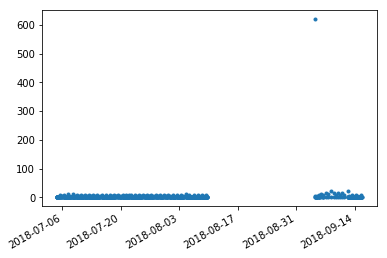

In [293]:
df2.dt_hour_diff.plot(linewidth=0, marker='.')

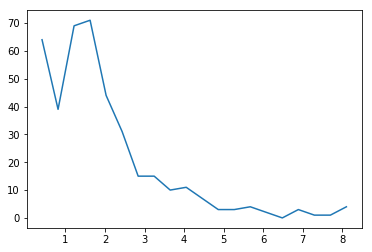

In [294]:
y, x = np.histogram(
    df2.dt_hour_diff[
        (df2.dt_hour_diff > df2.dt_hour_diff.quantile(.05)) 
        & (df2.dt_hour_diff < df2.dt_hour_diff.quantile(.95))
    ], bins=20)
x = x[1:]
plt.plot(x, y)

In [ ]:
from scipy.optimize import curve_fit

def func_to_fit(x, a, b):
    return a * np.exp(-b * x)

popt, pcov = curve_fit(func_to_fit, x, y, bounds=((0, 0), (1000000, 3)))

plt.figure()
plt.plot(x, y, 'ko', label="Original Noised Data")
plt.plot(x, func_to_fit(x, *popt), 'r-', label="Fitted Curve")
print(popt)
plt.legend()
# plt.show()

In [296]:
df2['prob_normal_diff'] = func_to_fit(df2.dt_hour_diff, *popt)
df2[df2.prob_normal_diff < .000001]

intervention outcome  dt_hour_diff  prob_normal_diff
2018-09-04 10:48:15          NaN     NaN    619.000556     1.282385e-120

In [297]:
latest_exp_ix = df2[df2.prob_normal_diff < .0001].index[-1]
df3 = df2.loc[latest_exp:, :]
df3.groupby(pd.Grouper(freq='1d')).size()

2018-09-04    12
2018-09-05    10
2018-09-06     6
2018-09-07     4
2018-09-08     2
2018-09-09     4
2018-09-10     4
2018-09-11     4
2018-09-12    18
2018-09-13    30
2018-09-14    30
2018-09-15    18
Freq: D, dtype: int64

In [311]:
%hist 300-400

import sys
sys.path.insert(0, '/home/mritter/code/preposterous')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import scipy.stats
import preposterous.preposterous as pp
pdf = pp.PrePostDF()
pdf.add_intervention(filename='data/reporter20180915.csv')
pdf.add_outcome(filename='data/reporter20180915.csv')
pdf.basic_info()
pdf.calculate_relative_effectiveness()
_ = pdf.plot_relative_effectiveness()
%debug
pdf = pp.PrePostDF()
pdf.add_intervention(filename='data/reporter20180915.csv')
pdf.add_outcome(filename='data/reporter20180915.csv')
pdf.basic_info()
pdf.outcomes(
    positive_outcomes=['Totally fine', 'Noticeable- barely'],
    negative_outcomes=['Noticeable- definitely', 'Distracting'],
    window=3
)
pdf.calculate_relative_effectiveness()
_ = pdf.plot_relative_effectiveness()
%hist 300
%hist 300-400


In [326]:
! head data/reporter20180915.csv

Timestamp of Report (GMT),Timestamp of Report (Local Time),Latitude,Longitude,Weather,Number of Photos Added,Ambient Audio (dB),Ambient Audio Description,Number of Steps,"What did you learn today?","Who are you with?","How many coffees did you have today?","Are you working?","How did you sleep?","Where are you?","What are you doing?","How does your stomach feel?","Choose intervention ","Choose intervention 02"
2018-07-04T20:22:00Z,"July 4, 2018 04:22:00pm","","","","0","","","-1",,,,,,,"Testing app for quantified self","Distracting ",,
2018-07-04T20:22:39Z,"July 4, 2018 04:22:39pm","","","","0","","","-1",,,,,,,,,,
2018-07-04T20:23:14Z,"July 4, 2018 04:23:14pm","","","","0","","","-1",,,,,,,,,,
2018-07-04T20:23:35Z,"July 4, 2018 04:23:35pm","","","","0","","","-1",,,,,,,"Test number 2","Distracting ",,
2018-07-04T20:33:38Z,"July 4, 2018 04:33:38pm","","","","0","","","-1",,,,,,,"Experiment 01","Distracting ",,
2018-07-04T20:43:20Z,"July 4, 2018 04:43:20pm","","","","0","","","-1",,,,,,

In [359]:
!pip install ipdb

  Running setup.py bdist_wheel for ipdb ... done
  Stored in directory: /home/mritter/.cache/pip/wheels/a8/0e/e2/ffc7bedd430bfd12e9dba3c4dd88906bc42962face85bc4df7
Successfully built ipdb


In [364]:
pdf2 = pp.PrePostDF()
pdf2.add_data(filename='data/reporter20180915.csv', intervention_column="Choose intervention 02", outcome_column="How does your stomach feel?")
pdf2.add_data(filename='data/reporter20180915.csv', intervention_column="Choose intervention ")
pdf2.df.index.isnull().any()
pdf2.basic_info()
pdf2.outcomes(
    positive_outcomes=['Totally fine', 'Noticeable- barely'],
    negative_outcomes=['Noticeable- definitely', 'Distracting'],
    window=3
)
pdf2.calculate_relative_effectiveness()
_ = pdf2.plot_relative_effectiveness()

> /home/mritter/code/preposterous/preposterous/preposterous.py(121)add_data()
    120                 ipdb.set_trace()
--> 121                 concat_df = concat_df.reindex(mono_intervention_ix).append(multi_intervention_rows)
    122 

ipdb> c


/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Earliest recording: 2018.07.04
Latest recording: 2018.09.15
Recordings per day: 6.0

Outcomes with n>5:
                          n   pct
                        246  0.56
Noticeable- definitely   76  0.17
Noticeable- barely       53  0.12
Totally fine             36  0.08
Distracting              32  0.07

Interventions with n>5:
Empty DataFrame
Columns: [n, pct]
Index: []

Long dataframe tail:
                            intervention             outcome
2018-09-15 10:55:38                  NaN         Distracting
2018-09-15 13:00:57       Mineral water          Distracting
2018-09-15 13:58:45  Breathing app (HRV)  Noticeable- barely
2018-09-15 15:21:21                  NaN  Noticeable- barely
2018-09-15 17:17:34                  NaN  Noticeable- barely


KeyError: 'prob'

In [353]:
%debug

> /home/mritter/code/quantifiedself/pandas/_libs/index.pyx(164)pandas._libs.index.IndexEngine.get_loc()

ipdb> u
> /home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/pandas/core/indexes/base.py(3080)get_loc()
   3078                 return self._engine.get_loc(key)
   3079             except KeyError:
-> 3080                 return self._engine.get_loc(self._maybe_cast_indexer(key))
   3081 
   3082         indexer = self.get_indexer([key], method=method, tolerance=tolerance)

ipdb> u
> /home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/pandas/core/indexes/numeric.py(419)get_loc()
    417             pass
    418         return super(Float64Index, self).get_loc(key, method=method,
--> 419                                                  tolerance=tolerance)
    420 
    421     @cache_readonly

ipdb> u
> /home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/pandas/core/indexin

ipdb> self.df.index
DatetimeIndex(['2018-07-04 20:22:00', '2018-07-04 20:22:39',
               '2018-07-04 20:23:14', '2018-07-04 20:23:35',
               '2018-07-04 20:33:38', '2018-07-04 20:43:20',
               '2018-07-04 21:26:52', '2018-07-04 22:18:02',
               '2018-07-04 22:43:48', '2018-07-05 00:44:01',
               ...
               '2018-09-15 13:00:57', '2018-09-15 13:58:45',
               '2018-09-15 15:21:21', '2018-09-15 17:17:34',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT'],
              dtype='datetime64[ns]', length=449, freq=None)
ipdb> q


In [338]:
! head data/Nutrition-Summary-2017-04-25-to-2018-09-15.csv

﻿Date,Meal,Time,Calories,Fat (g),Saturated Fat,Polyunsaturated Fat,Monounsaturated Fat,Trans Fat,Cholesterol,Sodium (mg),Potassium,Carbohydrates (g),Fiber,Sugar,Protein (g),Vitamin A,Vitamin C,Calcium,Iron,Note
2017-04-25,Dinner,,334.5,15.4,4.8,3.0,5.4,0.0,558.0,413.0,207.0,26.2,1.0,1.6,22.9,16.2,0.0,16.4,22.7,N:Distracting 
2017-04-26,Breakfast,,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,
2017-04-26,Lunch,,381.5,7.3,0.0,0.1,0.0,0.0,25.0,1073.1,470.9,58.1,6.8,12.9,21.4,17.0,43.4,5.4,20.5,
2017-04-26,Dinner,,257.0,6.9,3.6,0.0,0.0,0.0,28.0,686.0,330.0,33.3,2.0,11.0,7.4,15.0,0.0,2.0,2.0,
2017-04-26,Snacks,,89.8,0.3,0.1,0.1,0.0,0.0,0.0,1.0,361.2,23.0,2.6,12.3,1.1,1.3,14.6,0.5,1.5,
2017-04-27,Breakfast,,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
2017-04-27,Lunch,,764.0,48.8,16.6,4.3,11.5,0.0,10.0,1051.0,1070.0,116.9,10.9,7.0,57.1,85.0,6.0,14.0,67.4,
2017-04-27,Dinner,,360.0,18.5,7.0,0.5,2.5,0.0,75.0,220.0,0.0,23.0,2.0,4.0,26.0,20.0,6.0,

In [344]:
pdf2.add_data(filename='data/Nutrition-Summary-2017-04-25-to-2018-09-15.csv', intervention_column='Meal')
pdf2.df.tail()

/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


intervention outcome
2018-09-14        Lunch     NaN
2018-09-14       Dinner     NaN
2018-09-15    Breakfast     NaN
2018-09-15    Breakfast     NaN
2018-09-15        Lunch     NaN

In [345]:
pdf2.df.sort_index()

intervention                 outcome
2017-04-25 00:00:00               Dinner                     NaN
2017-04-26 00:00:00               Snacks                     NaN
2017-04-26 00:00:00            Breakfast                     NaN
2017-04-26 00:00:00                Lunch                     NaN
2017-04-26 00:00:00               Dinner                     NaN
2017-04-27 00:00:00                Lunch                     NaN
2017-04-27 00:00:00               Dinner                     NaN
2017-04-27 00:00:00            Breakfast                     NaN
2017-04-28 00:00:00            Breakfast                     NaN
2017-04-28 00:00:00                Lunch                     NaN
2017-04-28 00:00:00               Dinner                     NaN
2017-04-29 00:00:00            Breakfast                     NaN
2017-04-29 00:00:00                Lunch                     NaN
2017-04-29 00:00:00               Dinner                     NaN
2017-04-30 00:00:00                Lunch                     NaN
2017-04-30 00:00:00               Dinner                     NaN
2017-04-30 00:00:00               Snacks                     NaN
2017-05-01 00:00:00               Dinner                     NaN
2017-05-01 00:00:00                Lunch                     NaN
2017-05-02 00:00:00                Lunch                     NaN
2017-05-02 00:00:00            Breakfast                     NaN
2017-05-03 00:00:00            Breakfast                     NaN
2017-05-03 00:00:00                Lunch                     NaN
2017-05-03 00:00:00               Dinner                     NaN
2017-05-04 00:00:00            Breakfast                     NaN
2017-05-04 00:00:00                Lunch                     NaN
2017-05-04 00:00:00               Dinner                     NaN
2017-05-05 00:00:00            Breakfast                     NaN
2017-05-05 00:00:00                Lunch                     NaN
2017-05-06 00:00:00            Breakfast                     NaN
...                                  ...                     ...
2018-09-14 00:00:00                Lunch                     NaN
2018-09-14 00:00:00            Breakfast                     NaN
2018-09-14 00:00:00            Breakfast                     NaN
2018-09-14 00:28:01                  NaN      Noticeable- barely
2018-09-14 01:45:13                  NaN      Noticeable- barely
2018-09-14 01:45:27                  NaN                        
2018-09-14 10:10:03                  NaN                        
2018-09-14 10:10:15                  NaN  Noticeable- definitely
2018-09-14 14:18:27                  NaN      Noticeable- barely
2018-09-14 14:45:13                  NaN      Noticeable- barely
2018-09-14 15:44:29  Breathing app (HRV)  Noticeable- definitely
2018-09-14 16:46:42  Breathing app (HRV)             Distracting
2018-09-14 17:53:35    Ginger tea (yogi)  Noticeable- definitely
2018-09-14 18:47:47                  NaN  Noticeable- definitely
2018-09-14 20:15:58       Mineral water   Noticeable- definitely
2018-09-14 21:09:24                  NaN      Noticeable- barely
2018-09-14 22:03:13       Mineral water   Noticeable- definitely
2018-09-14 22:55:40                  NaN      Noticeable- barely
2018-09-15 00:00:00            Breakfast                     NaN
2018-09-15 00:00:00                Lunch                     NaN
2018-09-15 00:00:00            Breakfast                     NaN
2018-09-15 00:48:46           Tums (1ct)             Distracting
2018-09-15 02:06:24           Tums (1ct)  Noticeable- definitely
2018-09-15 02:06:48                  NaN                        
2018-09-15 10:55:32                  NaN                        
2018-09-15 10:55:38                  NaN             Distracting
2018-09-15 13:00:57       Mineral water              Distracting
2018-09-15 13:58:45  Breathing app (HRV)      Noticeable- barely
2018-09-15 15:21:21                  NaN      Noticeable- barely
2018-09-15 17:17:34                  NaN      Noticeable- barel

Earliest recording: 2017.04.25
Latest recording: 2018.09.15
Recordings per day: 2.0

Outcomes with n>5:
                          n   pct
                        246  0.56
Noticeable- definitely   76  0.17
Noticeable- barely       53  0.12
Totally fine             36  0.08
Distracting              32  0.07

Interventions with n>5:
             n   pct
Lunch      179  0.30
Breakfast  170  0.29
Dinner     154  0.26
Snacks      77  0.13

Long dataframe tail:
           intervention outcome
2018-09-14        Lunch     NaN
2018-09-14       Dinner     NaN
2018-09-15    Breakfast     NaN
2018-09-15    Breakfast     NaN
2018-09-15        Lunch     NaN


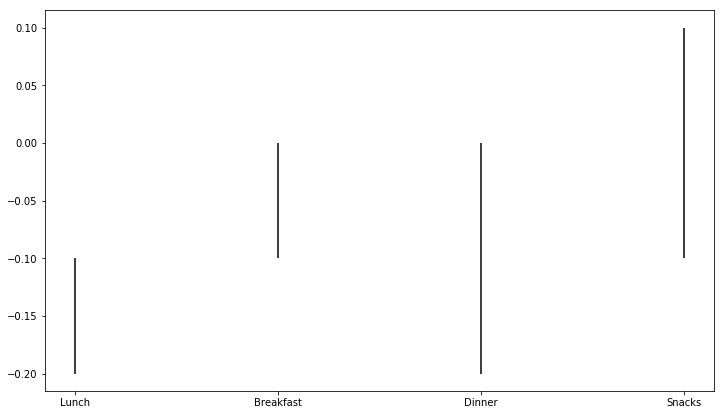

In [347]:
pdf2.basic_info()
pdf2.outcomes(
    positive_outcomes=['Totally fine', 'Noticeable- barely'],
    negative_outcomes=['Noticeable- definitely', 'Distracting'],
    window=3
)
pdf2.calculate_relative_effectiveness()
_ = pdf2.plot_relative_effectiveness()

In [314]:
pdf2 = pp.PrePostDF(outcome_col_name="Choose intervention 02")
pdf2.add_intervention(filename='data/reporter20180915.csv', starttime=latest_exp_ix)
pdf2.add_outcome(filename='data/reporter20180915.csv', starttime=latest_exp_ix)
pdf2.basic_info()
pdf2.outcomes(
    positive_outcomes=['Totally fine', 'Noticeable- barely'],
    negative_outcomes=['Noticeable- definitely', 'Distracting'],
    window=3
)
pdf2.calculate_relative_effectiveness()
_ = pdf2.plot_relative_effectiveness()

Earliest recording: 2018.07.07
Latest recording: 2018.09.15
Recordings per day: 2.2

Outcomes with n>5:
                         n   pct
Noticeable- definitely  25  0.32
                        24  0.31
Noticeable- barely      18  0.23
Distracting             10  0.13

Interventions with n>5:
Empty DataFrame
Columns: [n, pct]
Index: []

Long dataframe tail:
                    intervention      outcome
2018-07-07 13:49:51          NaN  Distracting
2018-07-15 11:01:27          NaN  Distracting
2018-07-15 11:01:27          NaN  Distracting
2018-07-17 10:36:46          NaN             
2018-07-17 10:36:46          NaN             


/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


KeyError: 'prob'